## 2次元の畳み込みニューラルネットワークスクラッチ

2次元に対応した畳み込みニューラルネットワーク（CNN）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


プーリング層なども作成することで、CNNの基本形を完成させます。クラスの名前はScratch2dCNNClassifierとしてください。

### データセットの用意

引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。


今回は白黒画像ですからチャンネルは1つしかありませんが、チャンネル方向の軸は用意しておく必要があります。


`(n_samples, n_channels, height, width)`の`NCHW`または`(n_samples, height, width, n_channels)`の`NHWC`どちらかの形にしてください。

In [1]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

Using TensorFlow backend.


### 【問題1】2次元畳み込み層の作成


1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。


フォワードプロパゲーションの数式は以下のようになります。

$$
a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}
$$

$a_{i,j,m}$ : 出力される配列のi行j列、mチャンネルの値


$i$ : 配列の行方向のインデックス


$j$ : 配列の列方向のインデックス


$m$ : 出力チャンネルのインデックス


$K$ : 入力チャンネル数


$F_{h}, F_{w}$ : 高さ方向（h）と幅方向（w）のフィルタのサイズ


$x_{(i+s),(j+t),k}$ : 入力の配列の(i+s)行(j+t)列、kチャンネルの値


$w_{s,t,k,m}$ : 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み


$b_m$ : mチャンネルへの出力のバイアス項


全てスカラーです。


次に更新式です。1次元畳み込み層や全結合層と同じ形です。

$$
w_{s,t,k,m}^{\prime} = w_{s,t,k,m} - \alpha \frac{\partial L}{\partial w_{s,t,k,m}} \\
b_{m}^{\prime} = b_{m} - \alpha \frac{\partial L}{\partial b_{m}}
$$

$\alpha$ : 学習率


$\frac{\partial L}{\partial w_{s,t,k,m}}$ : $w_{s,t,k,m}$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial b_{m}}$ : $b_{m}$ に関する損失 $L$ の勾配


勾配 $\frac{\partial L}{\partial w_{s,t,k,m}}$ や $\frac{\partial L}{\partial b_{m}}$ を求めるためのバックプロパゲーションの数式が以下である。

$$
\frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1} \frac{\partial L}{\partial a_{i,j,m}}x_{(i+s)(j+t),k}\\
\frac{\partial L}{\partial b_{m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}
$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi行j列、mチャンネルの値


$N_{out,h},N_{out,w}$ : 高さ方向（h）と幅方向（w）の出力のサイズ


前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_{i,j,k}} = \sum_{m=0}^{M-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1} \frac{\partial L}{\partial a_{(i-s),(j-t),m}}w_{s,t,k,m}
$$

$\frac{\partial L}{\partial x_{i,j,k}}$ : 前の層に流す誤差の配列のi列j行、kチャンネルの値


$M$ : 出力チャンネル数


ただし、 $i-s<0$ または $i-s>N_{out,h}-1$ または $j-t<0$ または $j-t>N_{out,w}-1$ のとき $\frac{\partial L}{\partial a_{(i-s),(j-t),m}} =0$ です。

In [2]:
# ＜参考＞
# https://github.com/oreilly-japan/deep-learning-from-scratch

class Conv2d:
    def __init__(self, initializer, optimizer, filter_num, C, filter_size, stride=1, pad=0):
        # initializerのメソッドを使い、self.Wとself.Bを初期化
        self.W = initializer.W(filter_num=filter_num,
                               C=C, filter_size=filter_size)
        self.B = initializer.B(filter_num)
        self.optimizer = optimizer  # 最適化手法
        self.stride = stride
        self.pad = pad

        self.X = None  # 中間データ（backward時に使用）
        self.col = None
        self.col_W = None

        self.dW = None  # 重み・バイアスパラメータの勾配
        self.db = None

    def forward(self, X):
        FN, C, FH, FW = self.W.shape  # （出力チャンネル、入力チャンネル、フィルタサイズ(縦)、フィルタサイズ(横)）
        N, C, H, W = X.shape  # （バッチサイズ、入力チャンネル, 特徴量数(縦), 特徴量数(横)）

        out_h, out_w = out_shape(H, FH, W, FW, self.stride, self.pad)

        col = im2col(X, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T  # フィルタを展開

        out = np.dot(col, col_W) + self.B
        out = out.reshape(N, out_h, out_w, -1).transpose(0,
                                                         3, 1, 2)  # (N, C, out_h ,out_w)

        self.X = X
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dA):
        FN, C, FH, FW = self.W.shape
        dA = dA.transpose(0, 2, 3, 1).reshape(-1, FN)

        self.dB = np.sum(dA, axis=0)  # （batch_size, n_output）
        self.dW = np.dot(self.col.T, dA)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dA, self.col_W.T)
        dX = col2im(dcol, self.X.shape, FH, FW,
                    self.stride, self.pad)  # (N, C, H ,W)

        self = self.optimizer.update(self)  # 重み、バイアスの更新
        return dX

In [3]:
def im2col(X, FH, FW, stride=1, pad=0):
    N, C, H, W = X.shape
    out_h, out_w = out_shape(H, FH, W, FW, stride, pad)

    img = np.pad(X, [(0, 0), (0, 0), (pad, pad),
                     (pad, pad)], 'constant')  # パディング

    col = np.zeros((N, C, FH, FW, out_h, out_w))
    for y in range(FH):
        y_max = y + stride * out_h
        for x in range(FW):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y: y_max: stride, x: x_max: stride]

    # (N,C,FH,FW,out_h,out_w)→(N,out_h,out_w,C,FH,FW)
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)
    return col

In [4]:
def col2im(dcol, X_shape, FH, FW, stride=1, pad=0):
    N, C, H, W = X_shape  # 入力データの形状（例：(10, 1, 28, 28)）
    out_h, out_w = out_shape(H, FH, W, FW, stride, pad)

    dcol = dcol.reshape(N, out_h, out_w, C, FH, FW).transpose(
        0, 3, 4, 5, 1, 2)  # (N,out_h,out_w,C,FH,FW)→(N,C,FH,FW,out_h,out_w)

    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
    for y in range(FH):
        y_max = y + stride * out_h
        for x in range(FW):
            x_max = x + stride * out_w
            img[:, :, y: y_max: stride, x: x_max: stride] += dcol[:, :, y, x, :, :]

    return img[:, :, pad: H + pad, pad: W + pad]

### 【問題2】2次元畳み込み後の出力サイズ

畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

$$
N_{h,out} =  \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1\\
N_{w,out} =  \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1
$$

$N_{out}$ : 出力のサイズ（特徴量の数）


$N_{in}$ : 入力のサイズ（特徴量の数）


$P$ : ある方向へのパディングの数


$F$ : フィルタのサイズ


$S$ : ストライドのサイズ


$h$ が高さ方向、 $w$ が幅方向である

In [5]:
def out_shape(H, FH, W, FW, S, P):
    out_h = int((H + 2 * P - FH) / S) + 1  # 出力の高さ
    out_w = int((W + 2 * P - FW) / S) + 1  # 出力の幅
    return out_h, out_w

### 【問題3】最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。

$$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$$

$P_{i,j}$ : i行j列への出力する場合の入力配列のインデックスの集合。 $S_{h}×S_{w}$ の範囲内の行（p）と列（q）


$S_{h}, S_{w}$ : 高さ方向（h）と幅方向（w）のストライドのサイズ


$(p,q)\in P_{i,j}$ : $P_{i,j}$ に含まれる行（p）と列（q）のインデックス


$a_{i,j,m}$ : 出力される配列のi行j列、kチャンネルの値


$x_{p,q,k}$ : 入力の配列のp行q列、kチャンネルの値

ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。


バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス $(p,q)$ を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。


In [6]:
class MaxPool2D:
    def __init__(self, pool_h=3, pool_w=3, stride=1, pad=0):
        self.pool_h = pool_h  # 対象領域の高さ
        self.pool_w = pool_w  # 対象領域の幅
        self.stride = stride
        self.pad = pad

        self.X = None
        self.arg_max = None

    def forward(self, X):
        N, C, H, W = X.shape
        out_h, out_w = out_shape(
            H, self.pool_h, W, self.pool_w, self.stride, self.pad)

        col = im2col(X, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)

        arg_max = np.argmax(col, axis=1)  # (N * out_h * out_w,)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(
            0, 3, 1, 2)  # (N, out_h, out_w, C)→(N, C, out_h, out_w)

        self.X = X
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)

        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size),
             self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dX = col2im(dcol, self.X.shape, self.pool_h,
                    self.pool_w, self.stride, self.pad)

        return dX

### 【問題4】（アドバンス課題）平均プーリングの作成

平均プーリング層のクラスAveragePool2Dを作成してください。


範囲内の最大値ではなく、平均値を出力とするプーリング層です。


画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。

In [7]:
class AveragePool2D():

    def __init__(self, P):
        self.P = P
        self.PA = None
        self.Pindex = None

    def forward(self, A):
        N, F, OH, OW = A.shape
        PS = self.P
        PH, PW = int(OH/PS), int(OW/PS)

        self.params = N, F, OH, OW, PS, PH, PW

        # プーリングフィルター
        self.PA = np.zeros([N, F, PH, PW])

        for n in range(N):
            # 出力チャンネル
            for ch in range(F):
                # 縦方向のスライド
                for row in range(PH):
                    # 横方向のスライド
                    for col in range(PW):
                        self.PA[n, ch, row, col] = \
                            np.mean(
                                A[n, ch, row*PS:row*PS+PS, col*PS:col*PS+PS])

        return self.PA

    def backward(self, dA):

        N, F, OH, OW, PS, PH, PW = self.params
        dP = np.zeros([N, F, OH, OW])

        for n in range(N):
            # 出力チャンネル
            for ch in range(F):
                # 縦方向のスライド
                for row in range(PH):
                    # 横方向のスライド
                    for col in range(PW):
                        tmp = np.zeros((PS*PS))
                        for i in range(PS*PS):
                            tmp[i] = dA[n, ch, row, col]/(PS*PS)

                        dP[n, ch, row*PS:row*PS+PS, col *
                            PS:col*PS+PS] = tmp.reshape(PS, PS)

        return dP

In [8]:
X = np.random.randint(0, 9, 36).reshape(1, 1, 6, 6)
print(X)

[[[[1 3 5 4 5 6]
   [8 5 0 6 4 4]
   [5 3 3 7 4 8]
   [7 6 8 7 5 7]
   [4 1 7 3 6 3]
   [7 8 6 4 0 6]]]]


In [9]:
Pooling = AveragePool2D(P=2)
A = Pooling.forward(X)

print(A.shape)
print(A)

(1, 1, 3, 3)
[[[[4.25 3.75 4.75]
   [5.25 6.25 6.  ]
   [5.   5.   3.75]]]]


In [10]:
dA = np.random.randint(0, 9, 9).reshape(A.shape)
print(dA)

[[[[4 7 3]
   [2 5 3]
   [4 7 5]]]]


In [11]:
dZ = Pooling.backward(dA)

print(dZ)

[[[[1.   1.   1.75 1.75 0.75 0.75]
   [1.   1.   1.75 1.75 0.75 0.75]
   [0.5  0.5  1.25 1.25 0.75 0.75]
   [0.5  0.5  1.25 1.25 0.75 0.75]
   [1.   1.   1.75 1.75 1.25 1.25]
   [1.   1.   1.75 1.75 1.25 1.25]]]]


### 【問題5】平滑化

平滑化するためのFlattenクラスを作成してください。


フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。


この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

In [12]:
class Flatten():
    def __init__(self):
        self.X_shape = None

    def forward(self, X):
        X_1d = X.reshape(X.shape[0], -1)
        self.X_shape = X.shape
        return X_1d

    def backward(self, dout):
        return dout.reshape(self.X_shape)

### 【問題6】学習と推定
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。


精度は低くともまずは動くことを目指してください。


In [13]:
class Scratch2dCNNClassifier():
    def __init__(self, epoch=10, batch_size=20, activation='Sigmoid', optimizer='SGD', initializer='SimpleInitializer',
                 sigma=0.1, lr=0.1, n_nodes1=200, n_nodes2=100, filter_num=3,  filter_size=3,
                 stride=1, pad=0, verbose=False):
        self.epoch = epoch
        self.batch_size = batch_size
        self.activation = activation
        self.optimizer = optimizer
        self.initializer = initializer
        self.sigma = sigma
        self.lr = lr
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.filter_num = filter_num  # フィルタの数
        self.filter_size = filter_size  # フィルタのサイズ（縦横同じ）
        self.stride = stride
        self.pad = pad
        self.verbose = verbose

    def fit(self, X, y, X_val=None, y_val=None):  # (n_samples, n_features), (n_samples, one_hot)
        if self.activation == 'Sigmoid':  # activationパラメータの選択
            activate1 = Sigmoid()
            activate2 = Sigmoid()
            activate3 = Sigmoid()
            activate4 = Sigmoid()
        elif self.activation == 'Tanh':
            activate1 = Tanh()
            activate2 = Tanh()
            activate3 = Tanh()
            activate4 = Tanh()
        elif self.activation == 'Relu':
            activate1 = Relu()
            activate2 = Relu()
            activate3 = Relu()
            activate4 = Relu()

        if self.optimizer == 'SGD':  # optimizerパラメータの選択
            optimizer1 = SGD(self.lr)
            optimizer2 = SGD(self.lr)
            optimizer3 = SGD(self.lr)
            optimizer4 = SGD(self.lr)
            optimizer5 = SGD(self.lr)
        elif self.optimizer == 'AdaGrad':
            optimizer1 = AdaGrad(self.lr)
            optimizer2 = AdaGrad(self.lr)
            optimizer3 = AdaGrad(self.lr)
            optimizer4 = AdaGrad(self.lr)
            optimizer5 = AdaGrad(self.lr)

        if self.initializer == 'SimpleInitializer':  # initializerパラメータの選択
            initializer1 = SimpleInitializer(self.sigma)
            initializer2 = SimpleInitializer(self.sigma)
            initializer3 = SimpleInitializer(self.sigma)
            initializer4 = SimpleInitializer(self.sigma)
            initializer5 = SimpleInitializer(self.sigma)
        elif self.initializer == 'XavierInitializer':
            initializer1 = XavierInitializer()
            initializer2 = XavierInitializer()
            initializer3 = XavierInitializer()
            initializer4 = XavierInitializer()
            initializer5 = XavierInitializer()
        elif self.initializer == 'HeInitializer':
            initializer1 = HeInitializer()
            initializer2 = HeInitializer()
            initializer3 = HeInitializer()
            initializer4 = HeInitializer()
            initializer5 = HeInitializer()

        self.conv1 = Conv2d(initializer1, optimizer1, self.filter_num,
                            X.shape[1], self.filter_size)  # 畳み込み層（＋プーリング層、活性化関数クラス）のインスタンス化
        self.activation1 = activate1
        self.pool1 = MaxPool2D()
        self.conv2 = Conv2d(initializer2, optimizer2,
                            self.filter_num, self.filter_num, self.filter_size)
        self.activation2 = activate2
        self.pool2 = MaxPool2D()
        self.conv3 = Conv2d(initializer3, optimizer3,
                            self.filter_num, self.filter_num, self.filter_size)
        self.activation3 = activate3

        self.flatten = Flatten()  # 平滑化層のインスタンス化

        OH, OW = self._out_shape(
            X.shape[2], self.filter_size, X.shape[3], self.filter_size, 'conv')  # 全結合前のサイズ
        OH, OW = self._out_shape(OH, self.filter_size,
                                 OW, self.filter_size, 'pool')
        OH, OW = self._out_shape(OH, self.filter_size,
                                 OW, self.filter_size, 'conv')
        OH, OW = self._out_shape(OH, self.filter_size,
                                 OW, self.filter_size, 'pool')
        OH, OW = self._out_shape(OH, self.filter_size,
                                 OW, self.filter_size, 'conv')
        size = OH * OW * self.filter_num

        self.FC1 = FC(size, self.n_nodes1, initializer4,
                      optimizer4)  # 全結合層（＋活性化関数クラス）のインスタンス化
        self.activation4 = activate4
        self.FC2 = FC(self.n_nodes1, y.shape[1], initializer5, optimizer5)
        self.activation5 = SoftmaxWithLoss()

        self.loss = []  # epochごとの損失を記録
        self.val_loss = []

        train_mini_batch = GetMiniBatch(
            X, y, self.batch_size)  # ミニバッチを取得するクラスのインスタンス化

        if X_val is not None and y_val is not None:  # 検証データが入力された場合
            test_mini_batch = GetMiniBatch(X_val, y_val)

        for i in range(self.epoch):
            self.mini_loss = []  # ミニバッチごとの損失を記録
            for mini_X_train, mini_y_train in train_mini_batch:
                self._forward(mini_X_train)  # フォワードプロパゲーション

                # バックプロパゲーション
                dA5, mini_loss = self.activation5.backward(
                    mini_y_train)  # 全結合層
                dZ4 = self.FC2.backward(dA5)
                dA4 = self.activation4.backward(dZ4)
                dZ3 = self.FC1.backward(dA4)
                dZ3 = self.flatten.backward(dZ3)  # shapeを戻す

                dA3 = self.activation3.backward(dZ3)  # 畳み込み層
                dP2 = self.conv3.backward(dA3)
                dZ2 = self.pool2.backward(dP2)
                dA2 = self.activation2.backward(dZ2)
                dP1 = self.conv2.backward(dA2)
                dZ1 = self.pool1.backward(dP1)
                dA1 = self.activation1.backward(dZ1)
                dX = self.conv1.backward(dA1)

                self.mini_loss.append(mini_loss)  # ミニバッチごとの損失

            loss = np.mean(self.mini_loss)  # epochごとの損失
            self.loss.append(loss)

            if X_val is not None and y_val is not None:  # 検証データが入力された場合
                self.mini_val_loss = []  # ミニバッチごとの損失を記録
                for mini_X_val, mini_y_val in test_mini_batch:
                    self._forward(mini_X_val)  # フォワードプロパゲーション

                    _, mini_val_loss = self.activation5.backward(
                        mini_y_val)  # バックプロパゲーション（損失を計算）

                    self.mini_val_loss.append(mini_val_loss)  # ミニバッチごとの損失

                # epochごとの損失（ミニバッジごとの損失の平均）
                val_loss = np.mean(self.mini_val_loss)
                self.val_loss.append(val_loss)

            if self.verbose:  # verboseをTrueにした際は損失関数の推移を出力
                print("epoch：", i+1, "　train_loss：", self.loss[i])

                if X_val is not None or y_val is not None:  # 検証データが入力された場合
                    print("epoch：", i+1, "　val_loss：", self.val_loss[i])

    def _forward(self, X):  # (n_samples, n_features)
        A1 = self.conv1.forward(X)  # 畳み込み層
        Z1 = self.activation1.forward(A1)
        P1 = self.pool1.forward(Z1)
        A2 = self.conv2.forward(P1)
        Z2 = self.activation2.forward(A2)
        P2 = self.pool2.forward(Z2)
        A3 = self.conv3.forward(P2)
        Z3 = self.activation3.forward(A3)

        Z3 = self.flatten.forward(Z3)  # 平滑化層

        A4 = self.FC1.forward(Z3)  # 全結合層
        Z4 = self.activation4.forward(A4)
        A5 = self.FC2.forward(Z4)
        Z5 = self.activation5.forward(A5)  # (n_samples, n_output)

        return Z5

    def _out_shape(self, H, FH, W, FW, layer):  # （高さ、フィルタの高さ、幅、フィルタの幅）
        if layer == 'conv':
            out_h = 1 + int((H + 2 * self.pad - FH) / self.stride)
            out_w = 1 + int((W + 2 * self.pad - FW) / self.stride)
        elif layer == 'pool':
            out_h = 1 + int((H - FH) / self.stride)
            out_w = 1 + int((W - FW) / self.stride)

        return out_h, out_w

    def predict(self, X):  # (n_samples, n_features)
        y_pred = self._forward(X)
        return np.argmax(y_pred, axis=1)

    def graphs(self):
        plt.figure(figsize=(8, 6))
        plt.plot(np.arange(len(self.loss)), self.loss,
                 linewidth=3.0, label="train")
        if X_val is not None or y_val is not None:  # 検証データが入力された場合
            plt.plot(np.arange(len(self.val_loss)), self.val_loss,
                     linewidth=3.0, label="val", color="orange")
        plt.title("loss")
        plt.xlabel("epochs")
        plt.ylabel("cross_entropy_error")
        plt.legend(frameon=True)
        plt.show()

In [14]:
# 全結合層のクラス

class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        # initializerのメソッドを使い、self.Wとself.Bを初期化
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.optimizer = optimizer  # 最適化手法

    def forward(self, Z1):  # (batch_size, n_nodes1)
        self.Z = Z1.copy()
        A = np.dot(Z1, self.W) + self.B  # (batch_size, n_nodes2)
        return A

    def backward(self, dA):  # (batch_size, n_nodes2)
        self.dW = np.dot(self.Z.T, dA)
        self.dB = np.sum(dA, axis=0)
        dZ = np.dot(dA, self.W.T)  # (batch_size, n_nodes1)

        self = self.optimizer.update(self)  # 重み、バイアスの更新
        return dZ

In [15]:
# 重みの初期値

# SimpleInitializerクラス
class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma

    def W(self, n_nodes1=None, n_nodes2=None, filter_num=None, C=None, filter_size=None):

        if filter_num is not None and C is not None and filter_size is not None:  # 畳み込み層
            W = self.sigma * \
                np.random.randn(filter_num, C, filter_size, filter_size)

        if n_nodes1 is not None and n_nodes2 is not None:  # 全結合層
            W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W

    def B(self, n_nodes2):
        B = np.zeros(n_nodes2)
        return B

# XavierInitializerクラス


class XavierInitializer:
    def __init__(self):
        pass

    def W(self, n_nodes1=None, n_nodes2=None, filter_num=None, C=None, filter_size=None):

        if filter_num and C and filter_size is not None:  # 畳み込み層
            W = np.random.randn(filter_num, C, filter_size,
                                filter_size) / np.sqrt(filter_num)

        else:  # 全結合層
            W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1)

        return W

    def B(self, n_nodes2):
        B = np.zeros(n_nodes2)
        return B

# HeInitializerクラス


class HeInitializer:
    def __init__(self):
        pass

    def W(self, n_nodes1=None, n_nodes2=None, filter_num=None, C=None, filter_size=None):

        if filter_num and C and filter_size is not None:  # 畳み込み層
            W = np.random.randn(filter_num, C, filter_size,
                                filter_size) * np.sqrt(2 / filter_num)

        else:  # 全結合層
            W = np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2 / n_nodes1)

        return W

    def B(self, n_nodes2):
        B = np.zeros(n_nodes2)
        return B

In [16]:
# 最適化手法

# SGDクラス
class SGD:
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        layer.W -= self.lr * layer.dW / \
            layer.dB.shape[0]  # (n_nodes1, n_nodes2)
        layer.B -= self.lr * layer.dB.mean(axis=0)  # (n_nodes2)
        return layer

# AdaGradのクラス


class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.hW = None
        self.hB = None

    def update(self, layer):
        if self.hW is None:
            self.hW = np.zeros(layer.W.shape)
        if self.hB is None:
            self.hB = np.zeros(layer.B.shape)

        self.hW += (layer.dW / layer.dB.shape[0]) ** 2
        self.hB += (layer.dB.mean(axis=0)) ** 2

        # (n_nodes1, n_nodes2)
        layer.W -= self.lr / np.sqrt(self.hW + 1e-7) * \
            layer.dW / layer.dB.shape[0]
        layer.B -= self.lr / np.sqrt(self.hB + 1e-7) * \
            layer.dB.mean(axis=0)  # (n_nodes2)
        return layer

In [17]:
# 活性化関数

# sigmoid関数のクラス
class Sigmoid:
    def __init__(self):
        self.Z = None

    def forward(self, A):  # (batch_size, n_nodes1)
        A = -709*(A <= -709) + A*(A > -709)  # オーバーフロー対策
        self.Z = 1 / (1 + np.exp(-A))
        return self.Z

    def backward(self, dZ):  # (batch_size, n_nodes1)
        dA = dZ * self.Z * (1 - self.Z)
        return dA

# Hyperbolic tangent関数のクラス


class Tanh:
    def __init__(self):
        self.Z = None

    def forward(self, A):  # (batch_size, n_nodes1)
        self.Z = np.tanh(A)
        return self.Z

    def backward(self, dZ):  # (batch_size, n_nodes1)
        dA = dZ * (1 - self.Z ** 2)
        return dA

# ReLU関数のクラス


class Relu:
    def __init__(self):
        self.X = None

    def forward(self, A):  # (batch_size, n_nodes1)
        self.X = A.copy()
        Z = np.maximum(0, A)
        return Z

    def backward(self, dZ):  # (batch_size, n_nodes1)
        dA = np.where(self.X > 0, dZ, 0)
        return dA

# softmax関数のクラス（with loss）


class SoftmaxWithLoss:
    def __init__(self):
        self.Z = None

    def forward(self, A):  # (batch_size, n_output)
        c = np.max(A)  # オーバーフロー対策
        self.Z = np.exp(A - c) / np.sum(np.exp(A - c), axis=1).reshape(-1, 1)
        return self.Z

    def backward(self, y):  # (batch_size, n_output)
        loss_sum = np.sum(y * np.log(self.Z), axis=1)  # 交差エントロピー誤差
        loss = -np.mean(loss_sum)

        dA = self.Z - y  # 損失の勾配 (batch_size, n_nodes1)
        return dA, loss

In [18]:
# ミニバッチを取得するクラス
class GetMiniBatch:
    def __init__(self, X, y, batch_size=10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self, item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [19]:
# MNISTデータセットのダウンロード
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [20]:
# 型変換、正規化
from sklearn.model_selection import train_test_split
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2)
print(X_train.shape)  # (48000, 784)
print(X_val.shape)  # (12000, 784)

(48000, 1, 28, 28)
(12000, 1, 28, 28)


In [21]:
# 正解ラベル値をone-hotエンコーディング
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape)  # (60000,)
print(y_train_one_hot.shape)  # (60000, 10)
print(y_train_one_hot.dtype)  # float64

(48000,)
(48000, 10)
float64


In [22]:
# 検証データ、テストデータもone-hot表現に変換する
y_val_one_hot = enc.fit_transform(y_val[:, np.newaxis])
print(y_val_one_hot.shape)
y_test_one_hot = enc.fit_transform(y_test[:, np.newaxis])
print(y_test_one_hot.shape)
(12000, 10)

(12000, 10)
(10000, 10)


(12000, 10)

In [23]:
# 学習
dnnc = Scratch2dCNNClassifier(verbose=True)
dnnc.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

epoch： 1 　train_loss： 2.3496283723799443
epoch： 1 　val_loss： 2.3051029014400015
epoch： 2 　train_loss： 0.9542905159591858
epoch： 2 　val_loss： 0.2894866238730532
epoch： 3 　train_loss： 0.24925406518744458
epoch： 3 　val_loss： 0.20850666018508826
epoch： 4 　train_loss： 0.18498648731744732
epoch： 4 　val_loss： 0.15699275829432727
epoch： 5 　train_loss： 0.1421781376219194
epoch： 5 　val_loss： 0.12553889224802864
epoch： 6 　train_loss： 0.11790433469473494
epoch： 6 　val_loss： 0.10862803288573221
epoch： 7 　train_loss： 0.10416191823374424
epoch： 7 　val_loss： 0.09988865812801885
epoch： 8 　train_loss： 0.09515904752357215
epoch： 8 　val_loss： 0.09461584143576161
epoch： 9 　train_loss： 0.08821585311935277
epoch： 9 　val_loss： 0.0905674347005073
epoch： 10 　train_loss： 0.08258107705693024
epoch： 10 　val_loss： 0.08915980749018519


In [24]:
# 学習（損失関数の推移も出力）
# 「activation='Tanh'、optimizer='SGD'、initializer='XavierInitializer'」の場合
dnnc2 = Scratch2dCNNClassifier(activation='Tanh', optimizer='SGD', initializer='XavierInitializer',
                                          sigma=0.005, lr=0.005, verbose=True)
dnnc2.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

epoch： 1 　train_loss： 0.6154052759848836
epoch： 1 　val_loss： 0.37390753781452973
epoch： 2 　train_loss： 0.33177824189890476
epoch： 2 　val_loss： 0.3000774462369166
epoch： 3 　train_loss： 0.2748674703171029
epoch： 3 　val_loss： 0.2593960844589657
epoch： 4 　train_loss： 0.23901406861900285
epoch： 4 　val_loss： 0.23160938845375412
epoch： 5 　train_loss： 0.21312682142777922
epoch： 5 　val_loss： 0.2104187321598646
epoch： 6 　train_loss： 0.19346518726717055
epoch： 6 　val_loss： 0.19386816346913674
epoch： 7 　train_loss： 0.17758876118686312
epoch： 7 　val_loss： 0.1801517576925713
epoch： 8 　train_loss： 0.16454452449742724
epoch： 8 　val_loss： 0.1691981376872977
epoch： 9 　train_loss： 0.15369014386743798
epoch： 9 　val_loss： 0.1599929771055739
epoch： 10 　train_loss： 0.14441638247673047
epoch： 10 　val_loss： 0.15233334956337177


In [25]:
# 学習（損失関数の推移も出力）
# 「activation='Relu'、optimizer='SGD'、initializer='HeInitializer'」の場合
dnnc3 = Scratch2dCNNClassifier(activation='Relu', optimizer='SGD', initializer='HeInitializer',
                                          sigma=0.002, lr=0.002, verbose=True)
dnnc3.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

epoch： 1 　train_loss： 2.0534575378319944
epoch： 1 　val_loss： 0.6487868965318694
epoch： 2 　train_loss： 0.4242326452278059
epoch： 2 　val_loss： 0.33316487769612424
epoch： 3 　train_loss： 0.3045140219132087
epoch： 3 　val_loss： 0.27794050973652884
epoch： 4 　train_loss： 0.2615699469036963
epoch： 4 　val_loss： 0.24695388395857334
epoch： 5 　train_loss： 0.23548606251095397
epoch： 5 　val_loss： 0.22891967263573132
epoch： 6 　train_loss： 0.2177378230447053
epoch： 6 　val_loss： 0.21724084213553957
epoch： 7 　train_loss： 0.20434946813299334
epoch： 7 　val_loss： 0.20873068339980838
epoch： 8 　train_loss： 0.1935520054733365
epoch： 8 　val_loss： 0.20165466406297078
epoch： 9 　train_loss： 0.18438103738824435
epoch： 9 　val_loss： 0.19617491581407395
epoch： 10 　train_loss： 0.17652577427208016
epoch： 10 　val_loss： 0.19245837150324618


In [26]:
# 推定
y_pred = dnnc.predict(X_test)

print("予測ラベル：{}".format(y_pred[:20]))
print("正解ラベル：{}".format(y_test[:20]))

予測ラベル：[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 8 4]
正解ラベル：[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


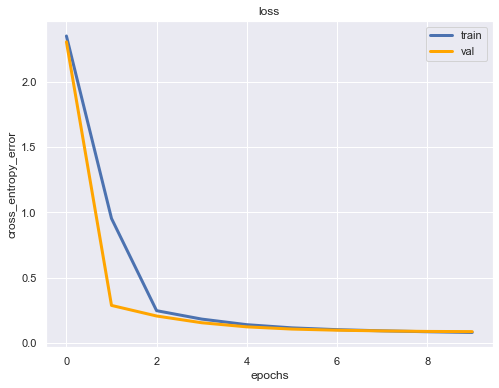

In [27]:
# 可視化する
dnnc.graphs()